In [82]:
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from matplotlib.pyplot import figure
from import_dfs import Datenbank

In [3]:
'''Datentypen
    cities: Stadtdaten
    tech_data: Technologiedaten
    improve_data: Verbesserungsfaktoren
    rf_pv_basis: Referenzstrekcen Basis
    rf_pv_pod: Referenzstrecken Pod
    rf_gv_basis: Referenzstrecken Güterverkehr Basis
    rf_gv_pod: Referenzstrecken Güterverkehr Pod
    rf_pv_routes: Strecken Personenverkehr 
    rf_gv_routes: Strecken Güterverkehr
'''

db = Datenbank()

In [4]:
df = db.rf_pv_basis.copy()  # init

def find_unique_modes(df):
    '''
    Bekommt eine Referenzstreckentabelle und ermittelt alle unique modes.
    Achtung: Für den Güterverehr muss die Anzahl an Schleifen durchläufen angepasst werden.
    '''
    x = set()
    for i in range(1,7):
        tmp = df.loc[:, f'mode_{i}'].unique().to_list()
        x.update(tmp)
        x.discard(np.nan)
    return x


def lower_and_underscores(l):
    '''
    Recives a list and lowers all words. In a second step it although replaces spaces with underscores.
    '''
    return [word.lower().replace(" ", '_').replace('-', '_') for word in l]


unique_modes = find_unique_modes(df)
unique_modes_fitted = lower_and_underscores(unique_modes)
unique_modes_dict = dict(zip(unique_modes, unique_modes_fitted))
unique_modes_dict[np.nan] = np.nan

f = lambda x: unique_modes_dict[x]  # Funktion um Werte aus dict in df zu schreiben
db.rf_pv_basis.loc[:, [f'mode_{i}' for i in range(1,7)]] = db.rf_pv_basis.loc[:, [f'mode_{i}' for i in range(1,7)]].applymap(f)  # Anwenden der Funktion

In [6]:
# Transformieren de DataFrames, so dass Verkehrsmittel in Spalten stehen 

df = db.rf_pv_basis.copy()  # init

df_new = pd.DataFrame(0, index=df.index, columns=unique_modes_fitted)

result = pd.concat([df, df_new], axis=1, sort=False)

def transform_df(row):
    '''
    Nimmt eine row und schreit die Gesamtkilometer je Verkehrmittel in das zur Spalte gehörige Feld.
    '''
    for i in range(1,7):
        mode = row.loc[f'mode_{i}']
        if mode not in [np.nan, np.NaN, 'nan']:
            row.loc[mode] += row.loc[f'mode_length_{i}']
        else:
            continue
    return row


result = result.apply(lambda row: transform_df(row), axis=1)

result = result.drop(columns=[f'mode_{i}' for i in range(1,7)] + [f'mode_length_{i}' for i in range(1,7)])

db.rf_pv_basis = result

In [10]:
# Berechnung der Emissionen je Kilometer

tech_data = db.tech_data.copy()  # init
rf_pv_basis = db.rf_pv_basis.copy()  # init

per_trip_costs = ["flugzeug", 'bus', 'tram', 'u_bahn']  # In der Literatur nur per Trip angegeben

fitted_index_lvl_0 = lower_and_underscores(tech_data.index.levels[0])  # modes werden angepasst
categorize = tech_data.index.levels[1].to_list()  # Kategorien, in denen die Bewertung vorgenommen wird
categorize.remove('verfuegbarkeit')
categorize.remove('auslastung')

tech_data.index.set_levels(fitted_index_lvl_0, level=0, inplace=True)  # Umbenennen der Kategorien
tech_data = pd.DataFrame(tech_data.loc[:, 'klassisch'])  # Ausprobieren für Szenario Klassisch muss angepasst werden

for mode in fitted_index_lvl_0:
        for cat in categorize:
            if mode in rf_pv_basis.columns.to_list() and not (cat == "kosten" and mode in per_trip_costs or cat == 'unfallrisiko'): # Standardfall
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = (rf_pv_basis.loc[:, mode] / 1000) * tech_data.loc[(mode, cat),:].values[0]
            elif mode in rf_pv_basis.columns.to_list() and (cat == "kosten" and mode in per_trip_costs):  # Kosten werden per Trip berechnet
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = rf_pv_basis.apply(lambda x: tech_data.loc[(mode, cat),:].values[0] if x.loc[mode] != 0 else 0, axis=1)
            elif mode in rf_pv_basis.columns.to_list() and cat == 'unfallrisiko':  # Unfallrisiko ist auf 1 Mrd. km bezogen
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = rf_pv_basis.loc[:, mode] * (tech_data.loc[(mode, cat),:].values[0] / 1000000000000)  # Trillion

                
def sum_emissions(df):
    for cat in categorize:
        df.loc[:, f'{cat}'] = df.loc[:,[f'{mode}_{cat}' for mode in unique_modes_fitted]].sum(axis=1)
    return df
            
rf_pv_basis = sum_emissions(rf_pv_basis)

rf_pv_basis.loc[:, 'main_mode'] = rf_pv_basis.loc[:, unique_modes_fitted].idxmax(axis=1)  # find mode with highest length percentage
rf_pv_basis.loc[:, 'num_modes'] = (rf_pv_basis.loc[:,unique_modes_fitted] > 0).sum(axis=1)   # find number of modes in row
rf_pv_basis.loc[:, 'only_mode'] = np.where(rf_pv_basis['num_modes'] == 1, True, False)  # if num modes == 1 -> only_mode = True

rf_pv_basis.loc[:, ['wartezeit', 'fahrtzeit', 'length']] = rf_pv_basis.loc[:, ['wartezeit', 'fahrtzeit', 'length']].round(0).astype(int)
rf_pv_basis.loc[:, 'kosten'] = rf_pv_basis.loc[:, 'kosten'].round(2) 
rf_pv_basis.loc[:, ['energieverbrauch', 'thg', 'nox', 'pm']] = rf_pv_basis.loc[:, ['energieverbrauch', 'thg', 'nox', 'pm']].round(4)

ausgabe = rf_pv_basis.loc[:, ['main_mode', 'only_mode', 'wartezeit', 'fahrtzeit', 'length', 'kosten', 'energieverbrauch', 'thg', 'nox', 'pm', 'unfallrisiko'] ]
rf_pv_basis.head()

,strecken_typ,name_verbindung,transferzeit,wartezeit,fahrtzeit,length,taxi,u_bahn,miv,bike_sharing,...,zug_nahverkehr_unfallrisiko,energieverbrauch,kosten,nox,pm,thg,unfallrisiko,main_mode,num_modes,only_mode
index,,,,,,,,,,,,,,,,,,,,,
0.0,UK,1.0,30.0000,0,30,2500,0.0,0.0,0.0,0.0,...,0.0,0.000,0.00,0.0000,0.0000,0.0000,3.550000e-08,zu_fuss,1,True
1.0,UK,1.0,8.0000,0,8,2600,0.0,0.0,0.0,0.0,...,0.0,0.000,0.00,0.0000,0.0000,0.0000,2.418000e-08,fahrrad,1,True
2.0,UK,1.0,16.0000,0,16,3600,0.0,0.0,3200.0,0.0,...,0.0,6.080,0.96,1.0880,1.2800,444.8000,1.272000e-08,miv,2,False
3.0,UK,1.0,19.0000,1,18,3790,0.0,1620.0,0.0,0.0,...,0.0,3.128,3.88,0.5648,0.0033,228.9300,9.732000e-09,bus,3,False
4.0,UK,1.0,7.0909,0,7,2600,0.0,0.0,0.0,0.0,...,0.0,0.065,0.00,0.0078,0.0000,9.5186,2.418000e-08,e_bike,1,True


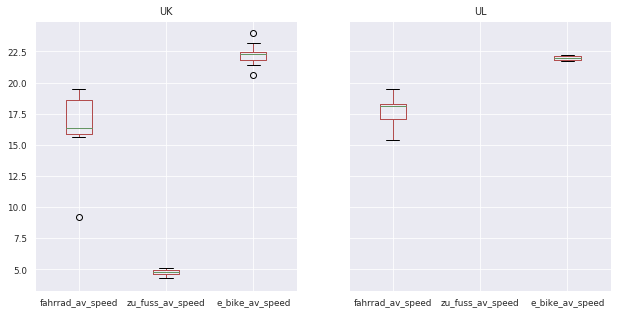

In [87]:
sns.set(context='paper')
sns.set_palette("Set1", n_colors=8, desat=.5)
plt.rcParams.update({'font.size': 14})

df = rf_pv_basis.copy()

av_speed_name = [f'{mode}_av_speed' for mode in unique_modes_fitted]
times_name = [f'{mode}_time' for mode in unique_modes_fitted]
df = pd.concat([df,pd.DataFrame(columns=av_speed_name+times_name)], sort=False)

def av_speed_calc(row):
    if row['only_mode']:
        row.loc[row['main_mode'] + '_av_speed'] = row.loc[row['main_mode']] / row['fahrtzeit'] * 0.06
    return row

df = df.apply(lambda row: av_speed_calc(row), axis=1)

solo_speeds = (df.loc[:,av_speed_name]
               .mean()
               .dropna()
               .to_dict())

solo_speeds['zu_fuss'] = solo_speeds.pop('zu_fuss_av_speed')
solo_speeds['e_bike'] = solo_speeds.pop('e_bike_av_speed')
solo_speeds['fahrrad'] = solo_speeds.pop('fahrrad_av_speed')

def calc_speeds(solo_speeds, df_start):
    df = df_start.copy()
    for key,val in solo_speeds.items():
        df[f'{key}_time'] = df[key] / val
    return df

df = calc_speeds(solo_speeds, df)
tmp = df.reindex(columns= av_speed_name + ['only_mode', 'strecken_typ'])
tmp = tmp.loc[ tmp.loc[:, 'only_mode'] == True ].dropna(axis=1, how='all').drop(columns='only_mode')
grouped = tmp.groupby('strecken_typ')

display(HTML(grouped.describe().T.to_html()))

with open('../tables/speeds.tex', 'w') as tf:
     tf.write(grouped.describe().T.to_latex())

grouped.boxplot()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)
fig.savefig('../plots/speeds.png', dpi=100)